In [211]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
from Functions import pivot_data_by_HSA, merge_and_rename_data, add_changes_by_week, create_column_names, create_collated_weekly_data,prep_training_test_data, cross_validation_leave_geo_out, calculate_metrics, add_labels_to_subplots, prep_training_test_data, calculate_maximum_reget
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [186]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")
columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'cases' in col]
HSA_weekly_data_no_cases_no_deaths = HSA_weekly_data_all.drop(columns=columns_to_remove)

columns_to_remove = [col for col in HSA_weekly_data_no_cases_no_deaths.columns if 'deaths' in col]
HSA_weekly_data_no_cases_no_deaths = HSA_weekly_data_no_cases_no_deaths.drop(columns=columns_to_remove)

# Polygons for mapping onto waves

In [187]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_40k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_92325/2686758069.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percent exceeding capacity 

In [188]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Parameters for functions

In [189]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 2
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [190]:
working_directory = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_models_period_sensitivity_time_period/"

# Full model

In [191]:
ROC_outcome_period = {}
accuracy_outcome_period = {}
MCC_outcome_period = {}
size_of_test_dataset = 1

outcome_periods = [2,4,6]


for outcome_period in outcome_periods:
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_full_exact_{outcome_period}"
    accuracy_list = f"accuracy_by_week_full_exact_{outcome_period}"
    MCC_list = f"MCC_by_week_full_exact_{outcome_period}"

    ROC_outcome_period[ROC_list] = []
    accuracy_outcome_period[accuracy_list] = []
    MCC_outcome_period[MCC_list] = []
    weeks_to_predict = range(1, 123 - size_of_test_dataset - weeks_in_future - train_weeks_for_initial_model)
    for prediction_week in weeks_to_predict:
            model_name_to_load = working_directory + "Full_model_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + "_" + str(outcome_period) + "_weeks"  + ".sav"
            clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

            print(prediction_week)
    

            X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

            X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            weights_full = weights_full[0].to_numpy()
            clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

            # Make predictions on the test set
            y_pred = clf_full_period.predict(X_test_full)
            y_pred_proba = clf_full_period.predict_proba(X_test_full)
            accuracy_outcome_period[accuracy_list].append(accuracy_score(y_test_full, y_pred))
            MCC_outcome_period[MCC_list].append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)
            if (y_test_full.sum()/len(y_test_full)).item() < 1:
                ROC_outcome_period[ROC_list].append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
            else:
                ROC_outcome_period[ROC_list].append(np.nan)
                print('all')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
9

# Naive classifier threhsold analysis

In [192]:
columns_to_select = HSA_weekly_data_all.filter(regex=f'HSA|beds_over_15_100k|weight').columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]


In [193]:

ROC_outcome_period_naive = {}
accuracy_outcome_period_naive = {}
MCC_outcome_period_naive = {}
size_of_test_dataset = 1

outcome_periods = [2,4, 6]

for outcome_period in outcome_periods:
    
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_naive_period_{outcome_period}"
    accuracy_list = f"accuracy_by_week_naive_period_{outcome_period}"
    MCC_list = f"MCC_by_week_naive_period_{outcome_period}"

    ROC_outcome_period_naive[ROC_list] = []
    accuracy_outcome_period_naive[accuracy_list] = []
    MCC_outcome_period_naive[MCC_list] = []
    weeks_to_predict = range(1, 123 - size_of_test_dataset - weeks_in_future - train_weeks_for_initial_model)

    for prediction_week in weeks_to_predict:

        print(prediction_week)
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
        weights_naive = weights_naive[0].to_numpy()
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        accuracy_outcome_period_naive[accuracy_list].append(accuracy_score(y_test_naive, y_pred))
        if (y_test_naive.sum()/len(y_test_naive)).item() < 1:
            ROC_outcome_period_naive[ROC_list].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        else:
            ROC_outcome_period_naive[ROC_list].append(np.nan)
            print('all')
        MCC_outcome_period_naive[MCC_list].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
9

# CDC A and CDC B 

In [194]:
selected_columns = HSA_weekly_data_all.filter(regex=f'HSA|cases|admits|perc_covid|beds_over_15_100k|weight').columns.tolist()

HSA_weekly_data_all = HSA_weekly_data_all[ selected_columns]

excluded_columns = [col for col in HSA_weekly_data_all.columns if 'delta' not in col]
CDC_data = HSA_weekly_data_all[ excluded_columns]

In [195]:
ROC_outcome_period_CDC_A = {}
accuracy_outcome_period_CDC_A = {}
MCC_outcome_period_CDC_A = {}
size_of_test_dataset = 1

outcome_periods = [2, 4, 6]
keep_output = False

for outcome_period in outcome_periods:
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_CDC_A_exact_{outcome_period}"
    accuracy_list = f"accuracy_by_week_CDC_A_exact_{outcome_period}"
    MCC_list = f"MCC_by_week_CDC_A_exact_{outcome_period}"

    ROC_outcome_period_CDC_A[ROC_list] = []
    accuracy_outcome_period_CDC_A[accuracy_list] = []
    MCC_outcome_period_CDC_A[MCC_list] = []
    
    weeks_to_predict = range(1, 123 - size_of_test_dataset - weeks_in_future - train_weeks_for_initial_model)
    
    for prediction_week in weeks_to_predict:
        model_name_to_load = working_directory + "CDC_A_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + "_" + str(outcome_period) + "_weeks" + ".sav"
        clf_CDC_A_period = pickle.load(open(model_name_to_load, 'rb'))

        print(prediction_week)

        X_train_CDC_A, y_train_CDC_A, weights_CDC_A, missing_data_train_HSA = prep_training_test_data(CDC_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

        X_test_CDC_A, y_test_CDC_A, weights_test_CDC_A, missing_data_test_HSA = prep_training_test_data(CDC_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
        weights_CDC_A = weights_CDC_A[0].to_numpy()
        clf_CDC_A_period.fit(X_train_CDC_A, y_train_CDC_A, sample_weight=weights_CDC_A)

        # Make predictions on the test set
        y_pred_CDC_A = clf_CDC_A_period.predict(X_test_CDC_A)
        y_pred_proba_CDC_A = clf_CDC_A_period.predict_proba(X_test_CDC_A)
        
        accuracy_outcome_period_CDC_A[accuracy_list].append(accuracy_score(y_test_CDC_A, y_pred_CDC_A))
        MCC_outcome_period_CDC_A[MCC_list].append((matthews_corrcoef(y_test_CDC_A, y_pred_CDC_A) + 1)/2)
        
        if (y_test_CDC_A.sum() / len(y_test_CDC_A)).item() < 1:
            ROC_outcome_period_CDC_A[ROC_list].append(roc_auc_score(y_test_CDC_A, y_pred_proba_CDC_A[:, 1]))
        else:
            ROC_outcome_period_CDC_A[ROC_list].append(np.nan)
            print('all')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
9

In [196]:
ROC_outcome_period_CDC_B = {}
accuracy_outcome_period_CDC_B = {}
MCC_outcome_period_CDC_B = {}
size_of_test_dataset = 1

outcome_periods = [2, 4, 6]
keep_output = True

for outcome_period in outcome_periods:
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_CDC_B_exact_{outcome_period}"
    accuracy_list = f"accuracy_by_week_CDC_B_exact_{outcome_period}"
    MCC_list = f"MCC_by_week_CDC_B_exact_{outcome_period}"

    ROC_outcome_period_CDC_B[ROC_list] = []
    accuracy_outcome_period_CDC_B[accuracy_list] = []
    MCC_outcome_period_CDC_B[MCC_list] = []
    
    weeks_to_predict = range(1, 123 - size_of_test_dataset - weeks_in_future - train_weeks_for_initial_model)
    
    for prediction_week in weeks_to_predict:
        model_name_to_load = working_directory + "CDC_B_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + "_" + str(outcome_period) + "_weeks" + ".sav"
        clf_CDC_B_period = pickle.load(open(model_name_to_load, 'rb'))

        print(prediction_week)

        X_train_CDC_B, y_train_CDC_B, weights_CDC_B, missing_data_train_HSA = prep_training_test_data(CDC_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

        X_test_CDC_B, y_test_CDC_B, weights_test_CDC_B, missing_data_test_HSA = prep_training_test_data(CDC_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
        weights_CDC_B = weights_CDC_B[0].to_numpy()
        clf_CDC_B_period.fit(X_train_CDC_B, y_train_CDC_B, sample_weight=weights_CDC_B)

        # Make predictions on the test set
        y_pred_CDC_B = clf_CDC_B_period.predict(X_test_CDC_B)
        y_pred_proba_CDC_B = clf_CDC_B_period.predict_proba(X_test_CDC_B)
        
        accuracy_outcome_period_CDC_B[accuracy_list].append(accuracy_score(y_test_CDC_B, y_pred_CDC_B))
        MCC_outcome_period_CDC_B[MCC_list].append((matthews_corrcoef(y_test_CDC_B, y_pred_CDC_B) + 1)/2)
        
        if (y_test_CDC_B.sum() / len(y_test_CDC_B)).item() < 1:
            ROC_outcome_period_CDC_B[ROC_list].append(roc_auc_score(y_test_CDC_B, y_pred_proba_CDC_B[:, 1]))
        else:
            ROC_outcome_period_CDC_B[ROC_list].append(np.nan)
            print('all')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
9

# No cases or deaths 

In [202]:
working_directory = '/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/No_cases_no_deaths/'
ROC_outcome_period_no_c_d = {}
accuracy_outcome_period_no_c_d = {}
MCC_outcome_period_no_c_d = {}
size_of_test_dataset = 1

outcome_periods = [2,4,6]


for outcome_period in outcome_periods:
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_no_c_d_exact_{outcome_period}"
    accuracy_list = f"accuracy_by_week_no_c_d_exact_{outcome_period}"
    MCC_list = f"MCC_by_week_no_c_d_exact_{outcome_period}"

    ROC_outcome_period_no_c_d[ROC_list] = []
    accuracy_outcome_period_no_c_d[accuracy_list] = []
    MCC_outcome_period_no_c_d[MCC_list] = []
    weeks_to_predict = range(1, 123 - size_of_test_dataset - weeks_in_future - train_weeks_for_initial_model)
    for prediction_week in weeks_to_predict:
            model_name_to_load = working_directory + "Threshold_outcome_period/No_cases_no_deaths_smaller_hyperparameters_" + time_period + "_" + str(prediction_week) + "_" + str(outcome_period) + "_weeks"  + ".sav"
            clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

            print(prediction_week)
    

            X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

            X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_no_cases_no_deaths, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            weights_full = weights_full[0].to_numpy()
            clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

            # Make predictions on the test set
            y_pred = clf_full_period.predict(X_test_full)
            y_pred_proba = clf_full_period.predict_proba(X_test_full)
            accuracy_outcome_period_no_c_d[accuracy_list].append(accuracy_score(y_test_full, y_pred))
            MCC_outcome_period_no_c_d[MCC_list].append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)
            if (y_test_full.sum()/len(y_test_full)).item() < 1:
                ROC_outcome_period_no_c_d[ROC_list].append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
            else:
                ROC_outcome_period_no_c_d[ROC_list].append(np.nan)
                print('all')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
9

# Add Maximum Regret 

In [206]:
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_full_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_naive_exact.pkl', 'rb') as f:
    ROC_by_week_naive_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_A_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_A_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_B_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_B_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_no_c_d_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact_removed = pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/percent_exceed_capacity.pkl', 'rb') as f:
    exceed_threshold= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CL_mod.pkl', 'rb') as f:
    ROC_by_week_CL_mod = pickle.load(f)


In [256]:
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CL_mod.pkl', 'wb') as f:
    pickle.dump(ROC_by_week_CL_mod, f)


In [257]:

model_metric_ROC_2 = {
    'roc_values_naive_2': list(ROC_outcome_period_naive.values())[0][-114:],
    'roc_values_CDC_A_2': list(ROC_outcome_period_CDC_A.values())[0][-114:],
    #'roc_values_CDC_B_2': list(ROC_outcome_period_CDC_B.values())[0][-114:],
    'roc_values_no_c_d': list(ROC_outcome_period_no_c_d.values())[0][-114:],
    'roc_values_full_2': list(ROC_outcome_period.values())[0][-114:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-114:]
}
model_metric_ROC_3 = {
    'ROC_by_week_naive_exact': ROC_by_week_naive_exact[-114:],
    'ROC_by_week_CDC_A_exact': ROC_by_week_CDC_A_exact[-114:],
    #'ROC_by_week_CDC_B_exact': ROC_by_week_CDC_B_exact[-114:],
     'ROC_by_week_full_exact_removed': ROC_by_week_full_exact_removed[-114:], 
    'ROC_by_week_full_exact': ROC_by_week_full_exact[-114:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-114:]
}
model_metric_ROC_4 = {
    'roc_values_naive_4': list(ROC_outcome_period_naive.values())[1][-114:],
    'roc_values_CDC_A_4': list(ROC_outcome_period_CDC_A.values())[1][-114:],
    #'roc_values_CDC_B_4': list(ROC_outcome_period_CDC_B.values())[1][-114:],
    'roc_values_no_c_d': list(ROC_outcome_period_no_c_d.values())[1][-114:],
    'roc_values_full_4': list(ROC_outcome_period.values())[1][-114:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-114:]
}

model_metric_ROC_6 = {
    'roc_values_naive_6': list(ROC_outcome_period_naive.values())[2][-114:],
    'roc_values_CDC_A_6': list(ROC_outcome_period_CDC_A.values())[2][-114:],
    #'roc_values_CDC_B_6': list(ROC_outcome_period_CDC_B.values())[2][-114:],
    'roc_values_no_c_d': list(ROC_outcome_period_no_c_d.values())[2][-114:],
    'roc_values_full_6': list(ROC_outcome_period.values())[2][-114:], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod[-114:]
}
weeks_to_predict = range(1, 114)


all_metrics = {}
all_metrics_2 = {}
all_metrics_3 = {}
all_metrics_4 = {}
all_metrics_6 = {}

all_metrics['ROC'] = model_metric_ROC
all_metrics_2['ROC'] = model_metric_ROC_2
all_metrics_3['ROC'] = model_metric_ROC_3
all_metrics_4['ROC'] = model_metric_ROC_4
all_metrics_6['ROC'] = model_metric_ROC_6


models_2 = ['Naive: 2', 'CDC A: 2', 'No cases or deaths: 2',  'Full: 2', 'CDC CL' ]
models_3 = ['Naive: 3',  'CDC A: 3', 'No cases or deaths: 3', 'Full: 3', 'CDC CL' ]
models_4 = ['Naive: 4',  'CDC A: 4', 'No cases or deaths: 4', 'Full: 4', 'CDC CL' ]
models_6 = ['Naive: 6',  'CDC A: 6', 'No cases or deaths: 6', 'Full: 6', 'CDC CL' ]

maximum_regret_by_model_ROC_2 =calculate_maximum_reget('ROC', all_metrics_2, models_2, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_3 =calculate_maximum_reget('ROC', all_metrics_3, models_3, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_4 =calculate_maximum_reget('ROC', all_metrics_4, models_4, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_6 =calculate_maximum_reget('ROC', all_metrics_6, models_6, time_period, weeks_to_predict)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


In [262]:
indices_for_CL_MR = []
for i, score in enumerate(maximum_regret_by_model_ROC_2['CDC CL']):
    if score < 0.6:
       indices_for_CL_MR.append(i)

# Graph 

0
1
2
3
4
5
6
7


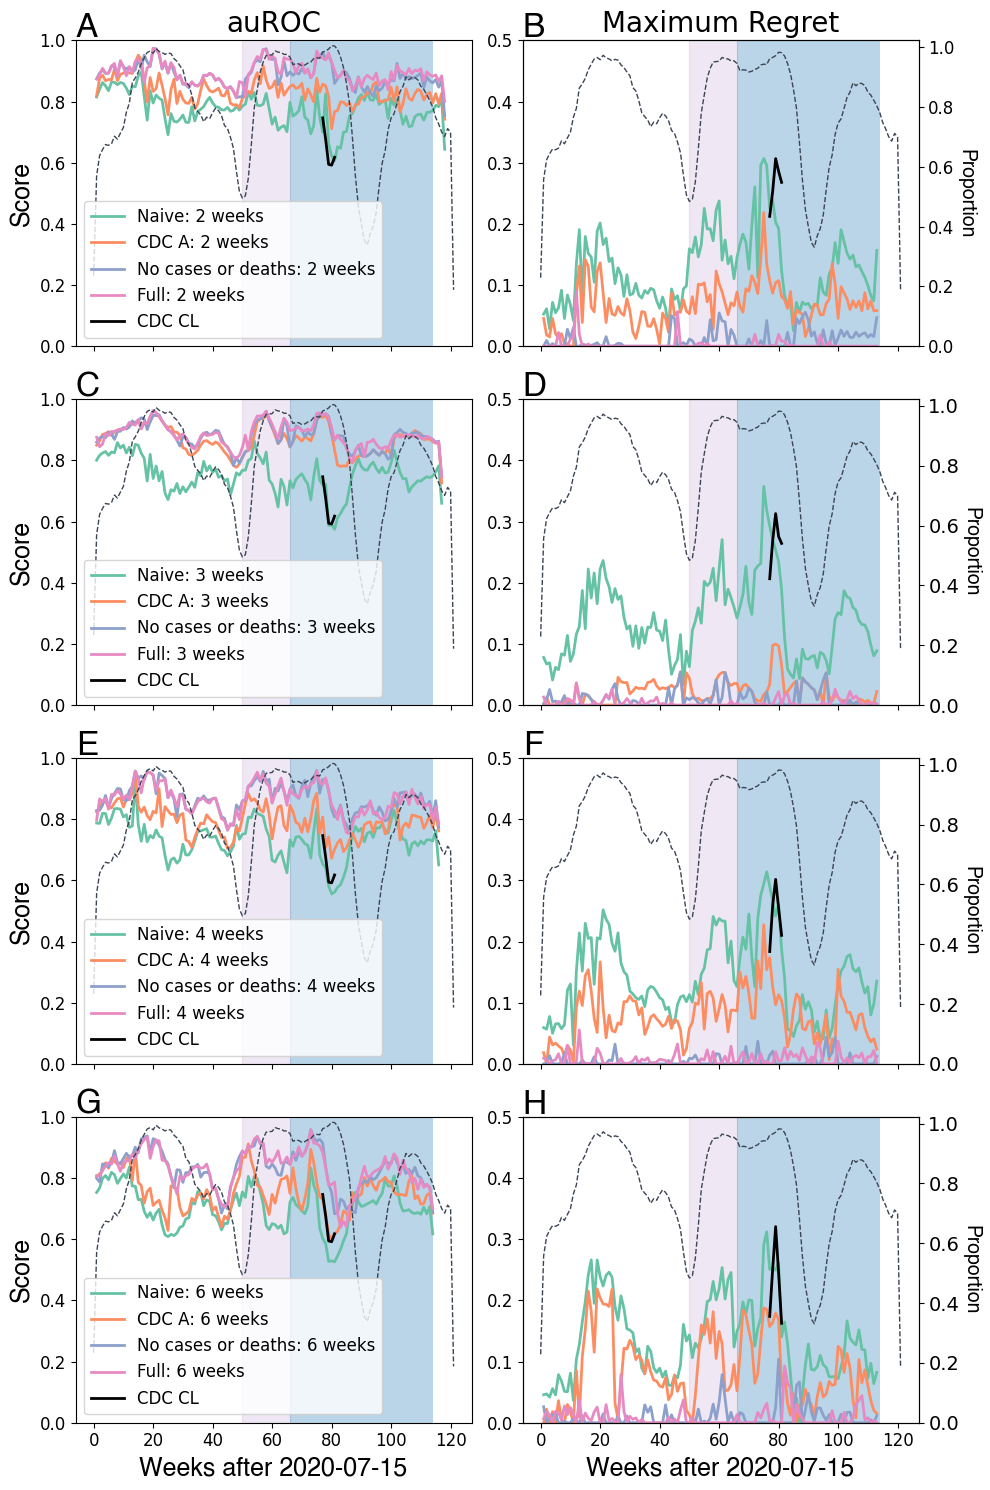

In [259]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 15), sharex = 'all')
axs = axs.ravel()


weeks_to_predict_2 = range(1, 119)
weeks_to_predict_3 = range(1, 118)
weeks_to_predict_4 = range(1, 117)
weeks_to_predict_6 = range(1, 115)

axs[0].plot(weeks_to_predict_2,  list(ROC_outcome_period_naive.values())[0], label='Naive: 2 weeks', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict_2,  list(ROC_outcome_period_CDC_A.values())[0], label='CDC A: 2 weeks', linewidth = 2, color = palette[1])
#axs[0].plot(weeks_to_predict_2,  list(ROC_outcome_period_CDC_B.values())[0], label='CDC B: 2 weeks', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict_2,  list(ROC_outcome_period_no_c_d.values())[0], label='No cases or deaths: 2 weeks', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict_2,  list(ROC_outcome_period.values())[0], label='Full: 2 weeks', linewidth = 2, color = palette[3])
axs[0].plot(range(77, 82), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[2].plot(weeks_to_predict_3,  ROC_by_week_naive_exact, label='Naive: 3 weeks', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict_3,  ROC_by_week_CDC_A_exact, label='CDC A: 3 weeks', linewidth = 2, color = palette[1])
#axs[2].plot(weeks_to_predict_3,  ROC_by_week_CDC_B_exact, label='CDC B: 3 weeks', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict_3,  ROC_by_week_full_exact_removed, label='No cases or deaths: 3 weeks', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict_3,  ROC_by_week_full_exact, label='Full: 3 weeks', linewidth = 2, color = palette[3])
axs[2].plot(range(77, 82), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[4].plot(weeks_to_predict_4,  list(ROC_outcome_period_naive.values())[1] , label='Naive: 4 weeks', linewidth = 2, color = palette[0])
axs[4].plot(weeks_to_predict_4,  list(ROC_outcome_period_CDC_A.values())[1], label='CDC A: 4 weeks', linewidth = 2, color = palette[1])
axs[4].plot(weeks_to_predict_4,  list(ROC_outcome_period_no_c_d.values())[1], label='No cases or deaths: 4 weeks', linewidth = 2, color = palette[2])
#axs[4].plot(weeks_to_predict_4,  list(ROC_outcome_period_CDC_B.values())[1], label='CDC B: 4 weeks', linewidth = 2, color = palette[2])
axs[4].plot(weeks_to_predict_4,  list(ROC_outcome_period.values())[1], label='Full: 4 weeks', linewidth = 2, color = palette[3])
axs[4].plot(range(77, 82), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[6].plot(weeks_to_predict_6,  list(ROC_outcome_period_naive.values())[2], label='Naive: 6 weeks', linewidth = 2, color = palette[0])
axs[6].plot(weeks_to_predict_6,  list(ROC_outcome_period_CDC_A.values())[2], label='CDC A: 6 weeks', linewidth = 2, color = palette[1])
#axs[6].plot(weeks_to_predict_6,  list(ROC_outcome_period_CDC_B.values())[2], label='CDC B: 6 weeks', linewidth = 2, color = palette[2])
axs[6].plot(weeks_to_predict_6,  list(ROC_outcome_period_no_c_d.values())[2], label='No cases or deaths: 6 weeks', linewidth = 2, color = palette[2])
axs[6].plot(weeks_to_predict_6,  list(ROC_outcome_period.values())[2], label='Full: 6 weeks', linewidth = 2, color = palette[3])
axs[6].plot(range(77, 82), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')


axs[0].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[2].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[4].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[6].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')


axs[0].set_title("auROC",fontsize=20)

# Plot MR 
weeks_to_predict = range(1, 114)
second_axs = axs[1].twinx()
models_2 = ['Naive: 2', 'CDC A: 2', 'No cases or deaths: 2', 'Full: 2', 'CDC CL']
for i, model in enumerate(models_2):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[1].plot(range(77, 82), maximum_regret_by_model_ROC_2[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[1].plot(weeks_to_predict, maximum_regret_by_model_ROC_2[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

second_axs.tick_params(axis='both', which='major', labelsize=12)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)

second_axs = axs[3].twinx()
models_3 = ['Naive: 3', 'CDC A: 3', 'No cases or deaths: 3', 'Full: 3', 'CDC CL']
for i, model in enumerate(models_3):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[3].plot(range(77, 82), maximum_regret_by_model_ROC_3[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[3].plot(weeks_to_predict, maximum_regret_by_model_ROC_3[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)

second_axs.tick_params(axis='y', labelsize=14)


second_axs = axs[5].twinx()
models_4 = ['Naive: 4', 'CDC A: 4', 'No cases or deaths: 4', 'Full: 4', 'CDC CL']
for i, model in enumerate(models_4):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[5].plot(range(77, 82), maximum_regret_by_model_ROC_4[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[5].plot(weeks_to_predict, maximum_regret_by_model_ROC_4[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)

second_axs.tick_params(axis='y', labelsize=14)



second_axs = axs[7].twinx()
models_6 = ['Naive: 6', 'CDC A: 6', 'No cases or deaths: 6', 'Full: 6', 'CDC CL']
for i, model in enumerate(models_6):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[7].plot(range(77, 82), maximum_regret_by_model_ROC_6[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[7].plot(weeks_to_predict, maximum_regret_by_model_ROC_6[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_title("Maximum Regret",fontsize=20)

for i in range( len(axs)):
    print(i)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)
axs[0].set_ylabel('Score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Score',**hfont,  fontsize = 18)
axs[4].set_ylabel('Score',**hfont,  fontsize = 18)
axs[6].set_ylabel('Score',**hfont,  fontsize = 18)

second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)

axs[0].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[4].set_ylim(0,1)
axs[6].set_ylim(0,1)

axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)
axs[5].set_ylim(0,0.5)
axs[7].set_ylim(0,0.5)

axs[6].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[7].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 1, loc='lower left', fontsize='12')
axs[2].legend(ncol = 1, loc='lower left', fontsize='12')
axs[4].legend(ncol = 1, loc='lower left', fontsize='12')
axs[6].legend(ncol = 1, loc='lower left', fontsize='12')

plt.tight_layout()

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_MR_naive_and_full_expanding_train_models_exact__{size_of_test_dataset}_week_training_period_by_metric.png', dpi = 300, bbox_inches='tight' )